# Практическая работа II - 4

In [10]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


def create_weighted_binary_crossentropy(zero_weight, one_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        # Calculate the binary crossentropy
        b_ce = binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return keras.backend.mean(weighted_b_ce)
    return weighted_binary_crossentropy


def unet(pretrained_weights = None, input_size = (256,256,1)):
    inputs = keras.Input(input_size)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = keras.Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr = 1e-4), loss=create_weighted_binary_crossentropy(0.1, 0.9), metrics=['accuracy'])
    # model.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [11]:
import sys
import cv2

nails_path = "data/nails/nails_segmentation"
images_path = nails_path + "/images"
labels_path = nails_path + "/labels"

images_dir = os.listdir(images_path)
labels_dir = os.listdir(labels_path)

images = ["/".join([images_path,img]) for img in images_dir]
labels = ["/".join([labels_path,img]) for img in labels_dir]

data = list(zip(images, labels))

import random
from operator import itemgetter

def random_data_iterator(n: int, list1, list2):
    # хотел сгенерировать исключение, но не разобрался ((
    # if n > len(list1) or len(list1) != len(list2):
    
    indices = range(len(list1))
    while True:
        ind = random.sample(indices, n)
        images = []
        labels = []
        for i in ind:
            images.append(list1[i])
            labels.append(list2[i])
        yield images, labels

import numpy as np
import matplotlib.pyplot as plt


def random_rotate_image(image, label, max_angle=180):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    angle = np.random.randint(-max_angle, max_angle)
    M = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_img = cv2.warpAffine(image, M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    rot_lab = cv2.warpAffine(label, M, image.shape[1::-1], flags=cv2.INTER_NEAREST)
    return (rot_img, rot_lab)


def get_random_crop(img, lbl, height, width):
    """Return a random crop of image"""
    max_x = img.shape[1] - width
    max_y = img.shape[0] - height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)
    return (img[y: y + height, x: x + width], 
           lbl[y: y + height, x: x + width])


def augmentation_data_iterator(
        n: int, 
        list1, 
        list2, 
        height=128, 
        width=128, 
        blur=True,
        blur_size=10,
        rotation=True,
        max_rotation_angle=180,
        mirror=True
):
    rotation_center = (height/2, width/2) 
    fit = random_data_iterator(n, list1, list2)
    while True:
        data = next(fit)
        images = []
        labels = []
        for i in range(n):
            img = cv2.imread(data[0][i]) / 255.
            lbl = cv2.imread(data[1][i], flags=cv2.IMREAD_GRAYSCALE) / 255.
            
            # Random rotate
            if rotation:
                img, lbl = random_rotate_image(img, lbl, max_rotation_angle)
            
            # Random choosing to flip horizontally
            if random.choice([True, False]):
                img = np.flip(img, axis=1)
                lbl = np.flip(lbl, axis=1)
            
            # Random choosing to flip vertically
            if random.choice([True, False]):
                img = np.flip(img, axis=0)
                lbl = np.flip(lbl, axis=0)
                
            # Random blur
            if blur:
                blur_coef = np.random.randint(1, blur_size)
                img = cv2.blur(img, (blur_coef, blur_coef))
                lbl = cv2.blur(lbl, (blur_coef, blur_coef))
            
            # Randomly cropping height x width piece from image
            img, lbl = get_random_crop(img, lbl, height, width)
            
            images.append(img)
            labels.append(lbl)
        yield images, labels

# n = 5      
# fit = augmentation_data_iterator(n, images, labels, blur=False)
# gen_images, gen_labels = next(fit)

# print("-- check shapes of training data: ", gen_images[0].shape, gen_labels[0].shape)
# print("-- label check:", np.unique(gen_labels[0]) )
# print("-- orig_label:", np.unique(cv2.imread(labels[0], flags=cv2.IMREAD_GRAYSCALE)))

# for i in range(n):
#     plt.subplot(n, 2, 2*i+1)
#     plt.imshow(gen_images[i])
    
#     plt.subplot(n, 2, 2*i+2)
#     plt.imshow(gen_labels[i])
    
            
# plt.show()

In [3]:
# Concatenate fout different images to one 256x256x3

def train_generator(batch_size=10):
    global images
    global labels
    while True:
        train_images, test_labels = next(augmentation_data_iterator(4*batch_size, images, labels, blur=False))
        train_images_scaled = np.array(train_images)
        test_labels_scaled = np.array(test_labels)

        # train_images_scaled = train_images_scaled / 255
        # test_labels_scaled = test_labels_scaled / 255

        train = np.array([np.block([
                [[train_images_scaled[i]],   [train_images_scaled[i+1]]],
                [[train_images_scaled[i+2]], [train_images_scaled[i+3]]]
            ]) for i in range(0, len(train_images_scaled), 4)])
        test = np.array([np.block([
                [test_labels_scaled[i],   test_labels_scaled[i+1]],
                [test_labels_scaled[i+2], test_labels_scaled[i+3]]
            ]) for i in range(0, len(test_labels_scaled), 4)])

        yield train, test

# x_train, y_train = next(train_generator())
# print("-- check shapes of training data: ", x_train[0].shape, y_train[0].shape)

# for i in range(2):
#     plt.subplot(2, 2, 2*i+1)
#     plt.imshow(x_train[i])
    
#     plt.subplot(2, 2, 2*i+2)
#     plt.imshow(y_train[i])
    
# plt.show()

In [12]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = './ckpt'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + '/' + name
                   for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print('Restoring from', latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print('Creating a new model')
    return unet(input_size=(256,256,3))

model = make_or_restore_model()

# Include the training loss in the folder name.
callbacks = [keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + '/ckpt-loss={loss:.2f}',
                    monitor="val_loss", verbose=1)
]

# # Calculate the weights for each class so that we can balance the data
# weights = class_weight.compute_class_weight('balanced',
#                                             np.unique(y_train[0]),
#                                             y_train[0])
# print("weights = ", weights)
model.summary()

Creating a new model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_________________________________________________________________________

In [13]:
def generate_train_data(n):
    train_x = np.zeros((n, 256, 256, 3))
    train_y = np.zeros((n, 256, 256))
    for i in range(n):
        img, lbl = next(train_generator(1))
        train_x[i] = img
        train_y[i] = lbl
    return train_x, train_y

x_train, y_train = generate_train_data(100)
x_test, y_test = generate_train_data(30)

In [14]:
print("x_train:", x_train.shape, "\ny_train:", y_train.shape)

x_train: (100, 256, 256, 3) 
y_train: (100, 256, 256)


In [15]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=5, batch_size=10, verbose=2,
                    callbacks=callbacks)

Epoch 1/5


ValueError: in user code:

    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-1-1d66f31e7416>:20 weighted_binary_crossentropy  *
        weighted_b_ce = weight_vector * b_ce
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1180 binary_op_wrapper
        raise e
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1496 _mul_dispatch
        return multiply(x, y, name=name)
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:518 multiply
        return gen_math_ops.mul(x, y, name)
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:6077 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 256 and 10 for '{{node weighted_binary_crossentropy/mul_4}} = Mul[T=DT_FLOAT](weighted_binary_crossentropy/add_3, weighted_binary_crossentropy/Mean)' with input shapes: [10,256,256], [10,256].


In [7]:
model.save("hw-4-unet")

INFO:tensorflow:Assets written to: hw-4-unet/assets


In [16]:
# model.fit(train_generator(batch_size=10), steps_per_epoch=10, epochs=5, verbose=2, callbacks=callbacks)
model.fit_generator(train_generator(2), steps_per_epoch=1, epochs=5, verbose=2, callbacks=callbacks)

/home/rustam/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/5


InvalidArgumentError:  Incompatible shapes: [2,256,256] vs. [2,256]
	 [[node gradient_tape/weighted_binary_crossentropy/mul_4/BroadcastGradientArgs (defined at <ipython-input-16-57a3755f5bcb>:2) ]] [Op:__inference_train_function_3598]

Function call stack:
train_function


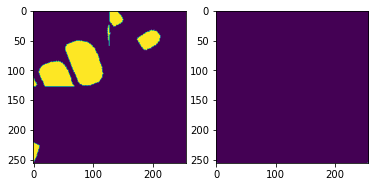

In [13]:
test_x, test_y = next(train_generator(batch_size=1))
predict_y = model.predict(test_x)

plt.subplot(1, 2, 1)
plt.imshow(test_y[0])

plt.subplot(1, 2, 2)
plt.imshow(predict_y[0])
plt.show()